<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Exploratory Data Analysis (EDA)</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. Datasets](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
* [2. Preprocessing & Feature Engineering](#2)
  * [2.1 Target variable distribution](#2.1)
  * [2.2 Missing values](#2.2)
  * [2.3 Exploratory Analysis](#2.3)
  * [2.4 Features Importance](#2.4)

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport

%matplotlib inline

In [151]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')
all_data = pd.read_csv('../data/interim/all_data.csv')
rentals = pd.read_csv('../data/interim/new_features_rentals.csv')
hourly_data.head()

,rental_date,rental_hour,rental_day,rental_month,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,temp,rhum,wdsp,rain_type,count
0,2021-03-01,2,1,3,2021,False,0,Monday,True,Winter,False,Night,-1.2,98,4,no rain,1
1,2021-03-01,7,1,3,2021,False,0,Monday,True,Winter,True,Morning,2.1,100,4,no rain,3
2,2021-03-01,8,1,3,2021,False,0,Monday,True,Winter,True,Morning,5.1,98,5,no rain,1
3,2021-03-01,9,1,3,2021,False,0,Monday,True,Winter,True,Morning,5.7,98,5,no rain,4
4,2021-03-01,10,1,3,2021,False,0,Monday,True,Winter,True,Morning,6.7,94,6,no rain,4


In [152]:
all_data.head(3)

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_hour,rental_day,rental_month,rental_year,...,working_day,season,peak,timesofday,date,rain,temp,rhum,wdsp,rain_type
0,2021-03-01 02:52:03,5,"[[53.3254, -6.25514], [53.3254, -6.25514], [53...",25.0,2021-03-01 14:04:42,2021-03-01 00:00:00,2,1,3,2021,...,True,Winter,False,Night,2021-03-01 02:00:00,0.0,-1.2,98,4,no rain
1,2021-03-01 07:35:15,21,"[[53.3428, -6.23861], [53.3428, -6.23862], [53...",25.0,2021-03-01 14:25:39,2021-03-01 00:00:00,7,1,3,2021,...,True,Winter,True,Morning,2021-03-01 07:00:00,0.0,2.1,100,4,no rain
2,2021-03-01 07:49:36,86,"[[53.3763, -6.27202], [53.3763, -6.27203], [53...",21.0,2021-03-02 16:27:20,2021-03-01 00:00:00,7,1,3,2021,...,True,Winter,True,Morning,2021-03-01 07:00:00,0.0,2.1,100,4,no rain


In [153]:
rentals.head(3)

,lastrentalstart,bikeid,coordinates,start_battery,lastgpstime,rental_date,rental_hour,rental_day,rental_month,rental_year,duration,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday
0,2021-03-01 02:52:03,5,"[[53.3254, -6.25514], [53.3254, -6.25514], [53...",25.0,2021-03-01 14:04:42,2021-03-01 00:00:00,2,1,3,2021,672.650000,False,0,Monday,True,Winter,False,Night
1,2021-03-01 07:35:15,21,"[[53.3428, -6.23861], [53.3428, -6.23862], [53...",25.0,2021-03-01 14:25:39,2021-03-01 00:00:00,7,1,3,2021,410.400000,False,0,Monday,True,Winter,True,Morning
2,2021-03-01 07:49:36,86,"[[53.3763, -6.27202], [53.3763, -6.27203], [53...",21.0,2021-03-02 16:27:20,2021-03-01 00:00:00,7,1,3,2021,1957.733333,False,0,Monday,True,Winter,True,Morning


In [154]:
hourly_data[['temp','wdsp','rhum','count']].describe()

,temp,wdsp,rhum,count
count,6966.000000,6966.00000,6966.000000,6966.000000
mean,10.742392,8.81137,80.545937,4.754378
std,5.002159,4.38365,11.918729,3.442080
min,-4.000000,1.00000,24.000000,1.000000
25%,7.025000,6.00000,73.000000,2.000000
50%,10.600000,8.00000,82.000000,4.000000
75%,14.500000,11.00000,90.000000,7.000000
max,26.300000,35.00000,100.000000,26.000000


In [155]:
hourly_data = hourly_data.astype({'holiday': 'category', 
                                  'dayofweek': 'category', 
                                  'working_day': 'category',
                                  'season': 'category', 
                                  'peak': 'category', 
                                  'rain_type': 'category', 
                                  'timesofday': 'category'
                                  })

In [156]:
hourly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6966 entries, 0 to 6965
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   rental_date   6966 non-null   object  
 1   rental_hour   6966 non-null   int64   
 2   rental_day    6966 non-null   int64   
 3   rental_month  6966 non-null   int64   
 4   rental_year   6966 non-null   int64   
 5   holiday       6966 non-null   category
 6   dayofweek_n   6966 non-null   int64   
 7   dayofweek     6966 non-null   category
 8   working_day   6966 non-null   category
 9   season        6966 non-null   category
 10  peak          6966 non-null   category
 11  timesofday    6966 non-null   category
 12  temp          6966 non-null   float64 
 13  rhum          6966 non-null   int64   
 14  wdsp          6966 non-null   int64   
 15  rain_type     6966 non-null   category
 16  count         6966 non-null   int64   
dtypes: category(7), float64(1), int64(8), object(1)
memo

In [157]:
hourly_data[['holiday','dayofweek','working_day','season','peak','timesofday','rain_type']].describe()

,holiday,dayofweek,working_day,season,peak,timesofday,rain_type
count,6966,6966,6966,6966,6966,6966,6966
unique,2,7,2,4,2,4,5
top,False,Saturday,True,Summer,False,Afternoon,no rain
freq,6684,1031,4722,1847,4634,2132,6324


In [158]:
profile = ProfileReport(hourly_data, title='Hourly Data', html={'style':{'full_width':True}})
profile.to_file(output_file='../reports/hourly_data_report.html')
# to_notebook_iframe() will print in the jupyter notebook's cell
# profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Rentals by Season

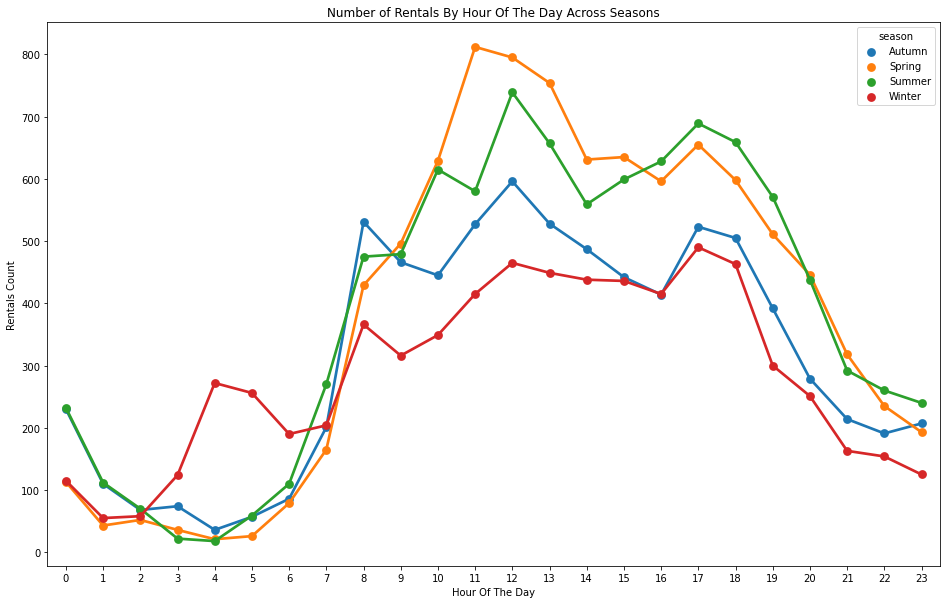

In [159]:
# 0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
# season_map = {0:'Spring', 1:'Summer', 2:'Fall', 3:'Winter'}
season_freq = hourly_data.groupby(['season', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
# season_freq['season'] = season_freq['season'].map(lambda d : season_map[d])
fig, ax = plt.subplots(figsize=(16, 10))
sns.pointplot(x=season_freq["rental_hour"], y=season_freq["count"], hue=season_freq["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Seasons")
plt.show()

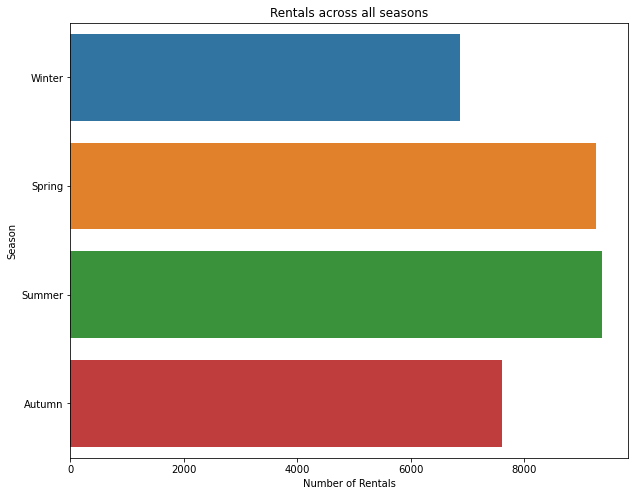

In [160]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=season_freq.groupby('season')['count'].sum().reset_index(), x='count', y='season', order=['Winter','Spring','Summer','Autumn'], ci=None)
ax.set(xlabel='Number of Rentals', ylabel='Season', title='Rentals across all seasons')
plt.show()

### Rentals by Days of the Week

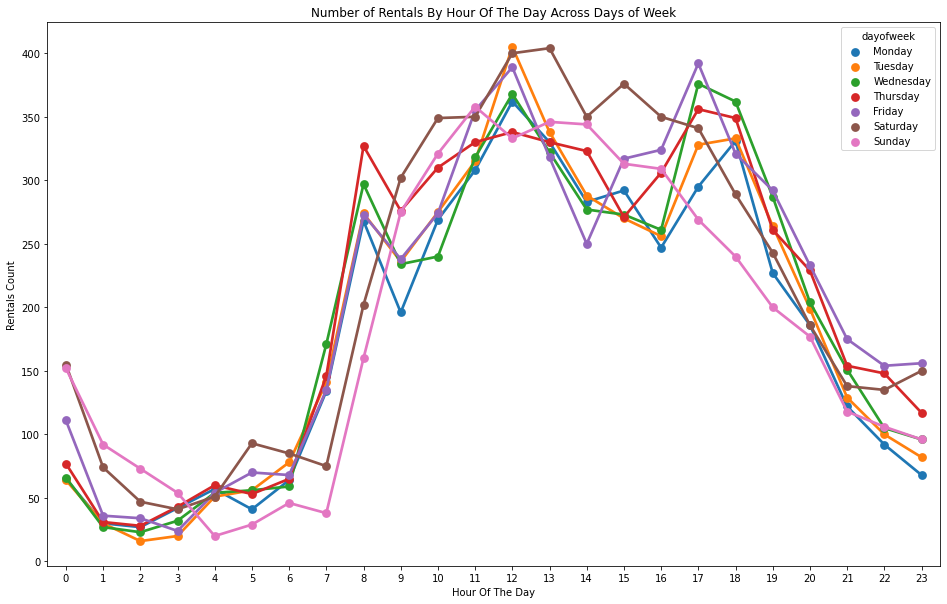

In [161]:
# day_of_week_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
day_of_week = hourly_data.groupby(['dayofweek', 'rental_hour'])['count'].agg('sum').reset_index(name='count')
# day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(16, 10))
sns.pointplot(x=day_of_week["rental_hour"], 
              y=day_of_week["count"], 
              hue=day_of_week["dayofweek"], 
              ax=ax,
              hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set(xlabel='Hour Of The Day', ylabel='Rentals Count', title="Number of Rentals By Hour Of The Day Across Days of Week")
plt.show()

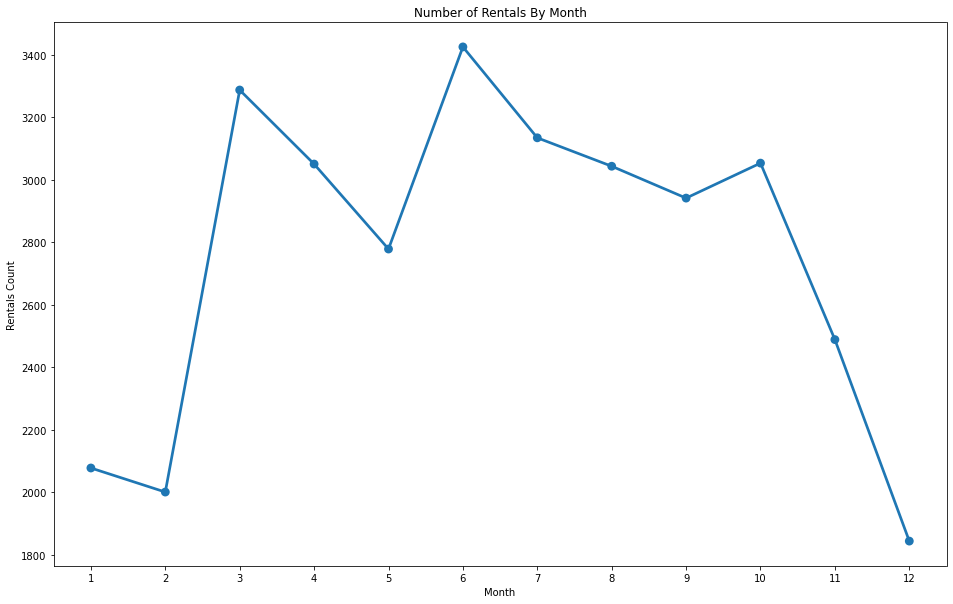

In [162]:
monthly_data = hourly_data.groupby('rental_month')['count'].agg('sum').reset_index(name='count')
# day_of_week['dayofweek'] = day_of_week['dayofweek'].map(lambda d : day_of_week_map[d])
fig, ax = plt.subplots(figsize=(16, 10))
sns.pointplot(x=monthly_data["rental_month"], 
              y=monthly_data["count"], 
              ax=ax)
ax.set(xlabel='Month', ylabel='Rentals Count', title="Number of Rentals By Month")
plt.show()

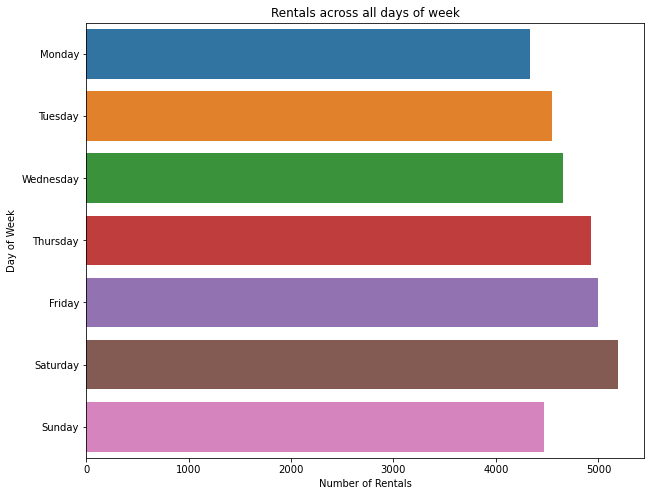

In [163]:
day_of_week = hourly_data.groupby('dayofweek')['count'].agg('sum').reset_index(name='count')
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=day_of_week, x='count', y='dayofweek', ci=None, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set(xlabel='Number of Rentals', ylabel='Day of Week', title='Rentals across all days of week')
plt.show()

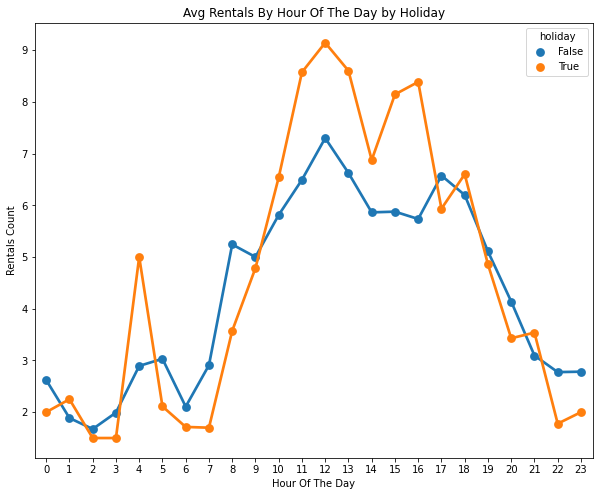

In [164]:
hourly_count = hourly_data.groupby(['rental_hour','holiday'])['count'].agg('mean').reset_index(name='count')

fig, ax = plt.subplots(figsize=(10, 8))
sns.pointplot(x=hourly_count['rental_hour'], y=hourly_count['count'], hue=hourly_count['holiday'], ax=ax)
ax.set(xlabel='Hour Of The Day', 
       ylabel='Rentals Count', 
       title="Avg Rentals By Hour Of The Day by Holiday")
plt.show()

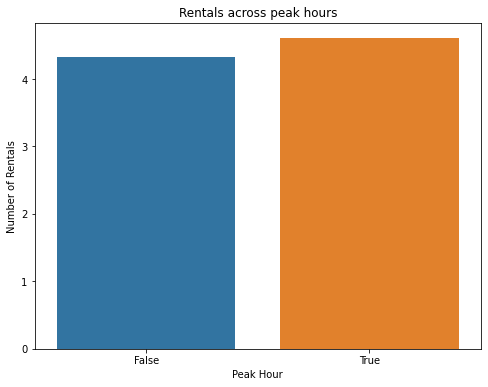

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=hourly_count, x='holiday', y='count', ci=None)
ax.set(xlabel='Peak Hour', ylabel='Number of Rentals', title='Rentals across peak hours')
plt.show()

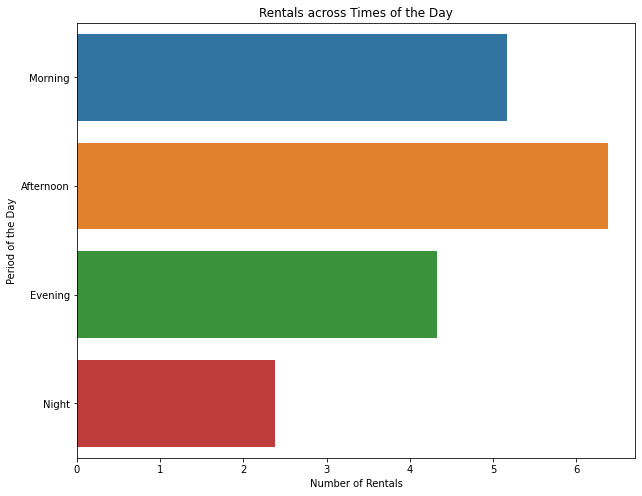

In [166]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=hourly_data, x='count', y='timesofday', ci=None, order=['Morning','Afternoon','Evening','Night'])
ax.set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')
plt.show()

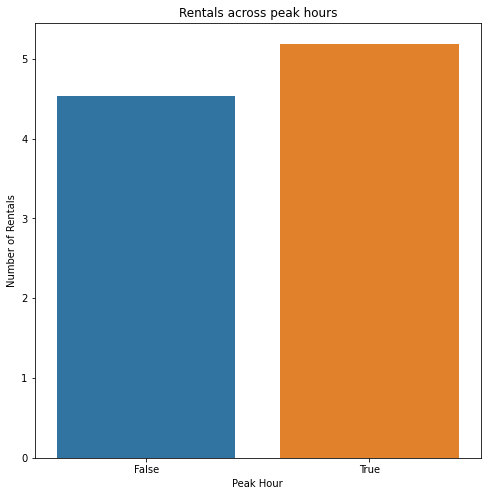

In [167]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(data=hourly_data, x='peak', y='count', ci=None)
ax.set(xlabel='Peak Hour', ylabel='Number of Rentals', title='Rentals across peak hours')
plt.show()

In [168]:
from scipy import stats
a = hourly_data['peak']
b = hourly_data['count']

stats.pointbiserialr(a,b)

PointbiserialrResult(correlation=0.08977835154621844, pvalue=6.05210059889326e-14)

## Battery distribution

In [169]:
battery_dist = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    battery_dist['battery_status'] = pd.cut(battery_dist['start_battery'], bins=bins, labels=labels, right=False)

    s = battery_dist.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
    
    return pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100}, labels)

In [170]:
group_battery_status(battery_dist)

,counts,per,per100
< 30%,2509,0.076862,7.7%
30% - 50%,5767,0.176669,17.7%
50% - 80%,14290,0.437766,43.8%
> 80%,10077,0.308703,30.9%


<AxesSubplot:xlabel='start_battery', ylabel='Count'>

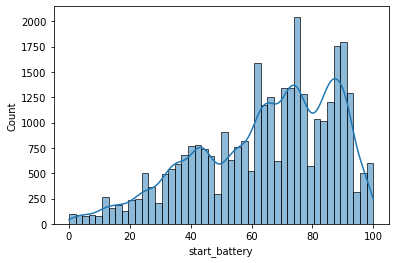

In [171]:
sns.histplot(data=rentals, x='start_battery', kde=True)

In [172]:
print(f"Mean of rentals duration: {round(all_data['duration'].mean(), 2)} minutes")

Mean of rentals duration: 958.96 minutes


## BoxPlot analysis

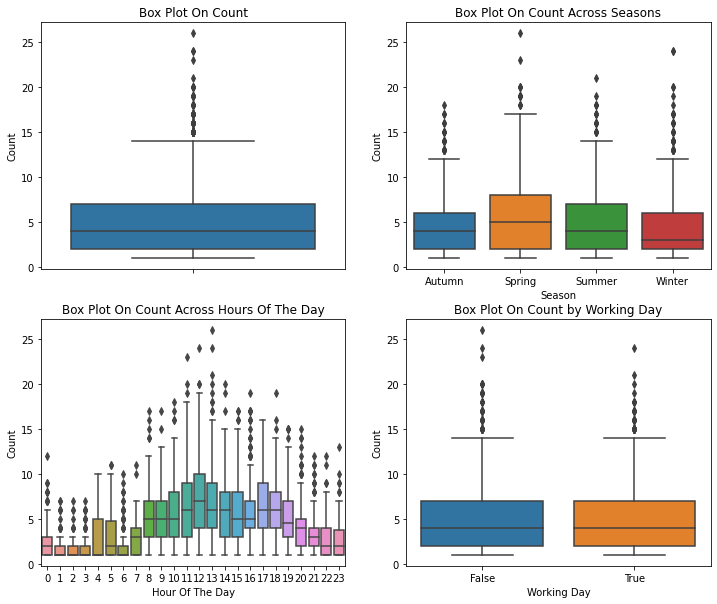

In [173]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=hourly_data,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_data,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_data,y="count",x="rental_hour",orient="v",ax=axes[1][0])
sns.boxplot(data=hourly_data,y="count",x="working_day",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Seasons")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hours Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count by Working Day")

plt.show()

## Correlation Matrix

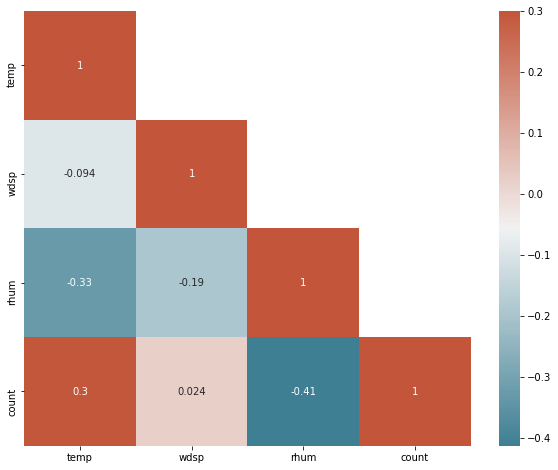

In [174]:
corrMatt = hourly_data[['temp','wdsp','rhum','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

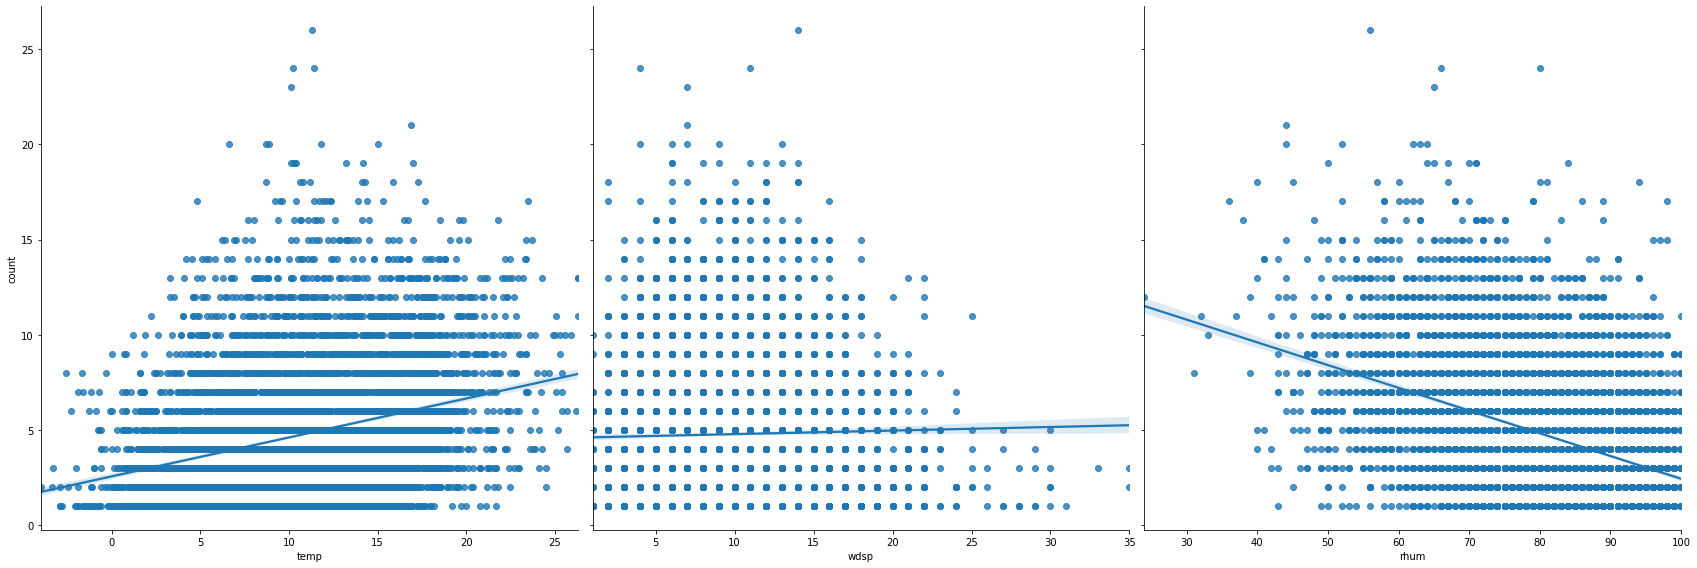

In [175]:
sns.pairplot(hourly_data, 
             x_vars=['temp','wdsp','rhum'],
             dropna=True, 
             y_vars='count', 
             height=8, 
             kind="reg", 
             palette='Set1')
plt.show()

## Outlier Analysis

In [176]:
hourly_data['count'].describe()

count    6966.000000
mean        4.754378
std         3.442080
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: count, dtype: float64

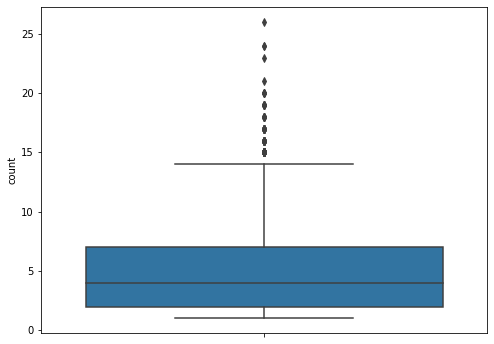

In [177]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=hourly_data,y="count",orient="v",ax=ax)
plt.show()

In [178]:
print(f"Outliers (#): {round(hourly_data[hourly_data['count'] > 15].shape[0], 2)}")
print(f"Outliers (%): {round((hourly_data[hourly_data['count'] > 15].shape[0] / hourly_data.shape[0])*100, 2)}%")

Outliers (#): 61
Outliers (%): 0.88%


In [179]:
hourlyDataOutliers = hourly_data[hourly_data['count'] > 15]
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())] 

In [180]:
hourlyDataOutliers['dayofweek'].value_counts()

Saturday     18
Sunday       13
Friday       10
Tuesday       7
Wednesday     6
Thursday      4
Monday        3
Name: dayofweek, dtype: int64

In [181]:
hourlyDataOutliers['holiday'].value_counts(normalize=True)

False    0.819672
True     0.180328
Name: holiday, dtype: float64

In [182]:
hourlyDataOutliers['working_day'].value_counts(normalize=True)

False    0.606557
True     0.393443
Name: working_day, dtype: float64

In [183]:
hourlyDataOutliers['season'].value_counts()

Spring    27
Winter    16
Summer    13
Autumn     5
Name: season, dtype: int64

In [184]:
daily_count = hourly_data.groupby('rental_date')['count'].sum().reset_index()
daily_count_no_outliers = hourlyDataWithoutOutliers.groupby('rental_date')['count'].sum().reset_index()

In [185]:
daily_count.describe()

,count
count,364.000000
mean,90.986264
std,27.873234
min,14.000000
25%,73.000000
50%,90.000000
75%,111.000000
max,171.000000


In [186]:
print(f"Mean of daily rentals = {round(daily_count['count'].mean(), 2)}")
print(f"Mean of daily rentals without Outliers = {round(daily_count_no_outliers['count'].mean(), 2)}")

Mean of daily rentals = 90.99
Mean of daily rentals without Outliers = 77.81


In [187]:
hourlyDataOutliers = hourlyDataOutliers.join(daily_count.set_index('rental_date'), on='rental_date', lsuffix='_hour', rsuffix='_day')

In [188]:
outliers_df = hourlyDataOutliers[hourlyDataOutliers['count_day'] > 110].sort_values(by='count_day', ascending=False)
outliers_df.head()

,rental_date,rental_hour,rental_day,rental_month,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,temp,rhum,wdsp,rain_type,count_hour,count_day
286,2021-03-17,11,17,3,2021,True,2,Wednesday,False,Winter,False,Morning,8.7,81,12,no rain,18,171
287,2021-03-17,12,17,3,2021,True,2,Wednesday,False,Winter,False,Afternoon,10.3,71,9,no rain,19,171
288,2021-03-17,13,17,3,2021,True,2,Wednesday,False,Winter,False,Afternoon,11.4,66,11,no rain,24,171
289,2021-03-17,14,17,3,2021,True,2,Wednesday,False,Winter,False,Afternoon,11.9,60,12,no rain,17,171
291,2021-03-17,16,17,3,2021,True,2,Wednesday,False,Winter,False,Afternoon,12.6,48,10,no rain,16,171


In [189]:
hourlyDataOutliers.to_csv('../data/interim/outliers.csv')

In [190]:
hourly_data[hourly_data['count'] > 20]

,rental_date,rental_hour,rental_day,rental_month,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,temp,rhum,wdsp,rain_type,count
288,2021-03-17,13,17,3,2021,True,2,Wednesday,False,Winter,False,Afternoon,11.4,66,11,no rain,24
325,2021-03-19,12,19,3,2021,False,4,Friday,True,Winter,False,Afternoon,10.2,80,4,no rain,24
596,2021-04-03,11,3,4,2021,False,5,Saturday,False,Spring,False,Morning,10.1,65,7,no rain,23
850,2021-04-17,13,17,4,2021,False,5,Saturday,False,Spring,False,Afternoon,11.3,56,14,no rain,26
2089,2021-06-22,13,22,6,2021,False,1,Tuesday,True,Summer,False,Afternoon,16.9,44,7,no rain,21


In [191]:
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())]
profile = ProfileReport(hourlyDataOutliers, title='Hourly Data without Outliers', html={'style':{'full_width':True}})
profile.to_file(output_file='../reports/hourlyDataWithoutOutliers.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

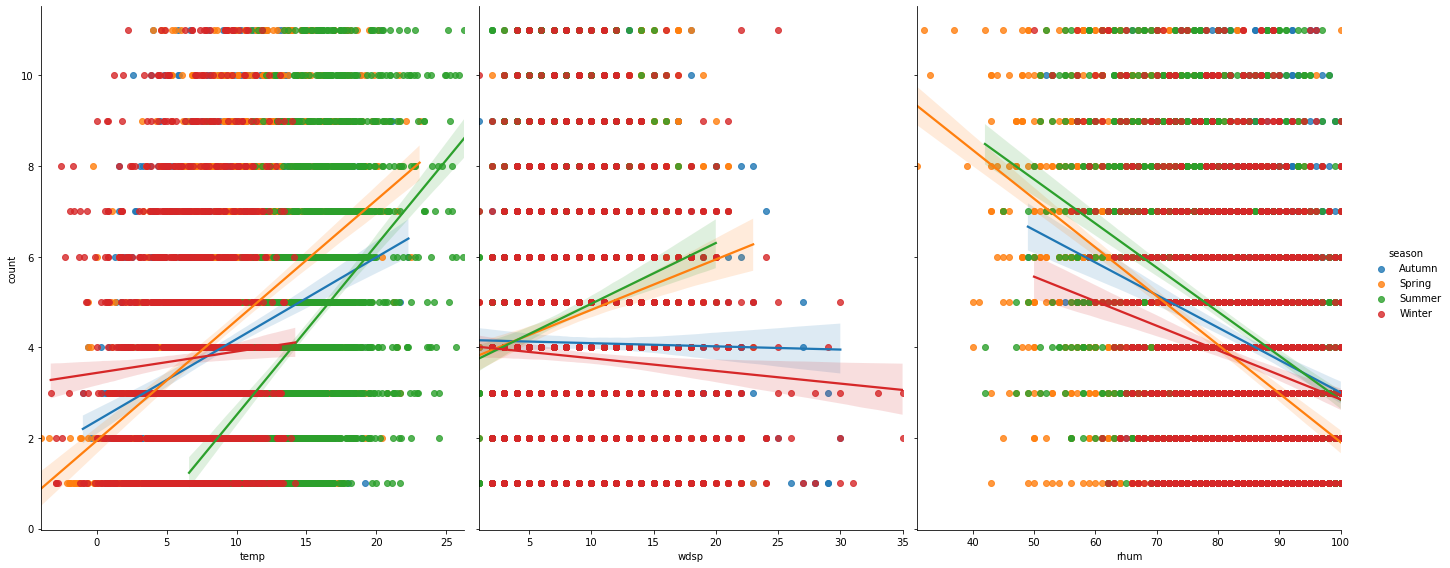

In [192]:
sns.pairplot(hourlyDataWithoutOutliers, 
             x_vars=['temp','wdsp','rhum'],
             dropna=True, 
             y_vars='count', height=8, aspect=0.8, kind="reg", hue='season')
plt.show()

## Distribution of numerical features

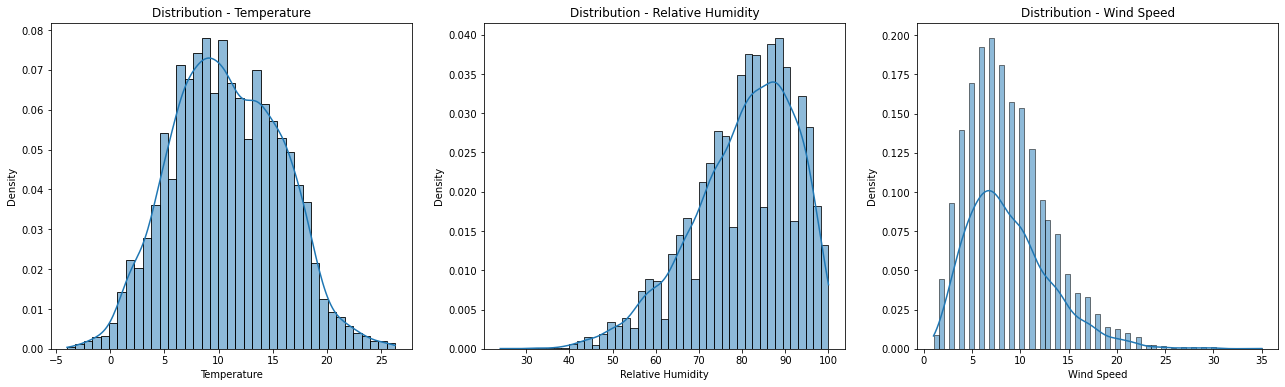

In [193]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.histplot(hourly_data['temp'],ax=ax0, stat='density', kde=True)
sns.histplot(hourly_data['rhum'],ax=ax1, stat='density', kde=True)
sns.histplot(hourly_data['wdsp'],ax=ax2, stat='density', kde=True)

ax0.set(xlabel='Temperature',title="Distribution - Temperature")
ax1.set(xlabel='Relative Humidity',title="Distribution - Relative Humidity")
ax2.set(xlabel='Wind Speed',title="Distribution - Wind Speed")

plt.show()

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini